In [0]:
!pip uninstall xgboost
!pip install xgboost-0.80-py2.py3-none-manylinux1_x86_64.whl

Uninstalling xgboost-0.80:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/xgboost-0.80.dist-info/*
    /usr/local/lib/python3.6/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.80
Processing ./xgboost-0.80-py2.py3-none-manylinux1_x86_64.whl


In [0]:
import numpy as np
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_csv('drive/My Drive/train.csv')
(nb_sample,nb_feature) = data.shape
print(data.shape)
data.head(5)

(58881, 129)


,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,InsuredInfo_8,InsuredInfo_9,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,...,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,1,A8,26,0.230769,2,3,1,0.492537,0.563636,0.225941,0.510720,0.0244,9,1,0.0,2,0.05,2,2,3,3,1,1,Female,NaN,Muslim,2,1,1,3,NaN,3,2,3,3,0.681159,NaN,0.492958,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
1,1,D2,26,1.000000,3,3,1,0.671642,0.781818,0.326360,0.453033,0.5000,3,1,0.5,2,1.00,1,2,8,3,1,1,Male,NaN,NaN,2,1,3,1,0.006667,1,3,2,2,NaN,0.490196,NaN,0.589286,4.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
2,1,D2,26,0.230769,2,3,1,0.626866,0.745455,0.393305,0.598310,0.0400,9,1,0.0,2,0.60,1,2,4,3,1,1,Male,Caucasian,Jewish,1,3,3,1,0.000833,1,1,2,3,NaN,0.558824,NaN,0.598214,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1,D4,26,0.230769,2,3,1,0.268657,0.690909,0.246862,0.410638,0.0300,9,1,0.0,2,0.00,1,2,6,2,1,1,Female,NaN,NaN,2,1,1,3,NaN,3,2,3,2,0.536232,NaN,0.478873,NaN,12.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
4,1,E1,10,0.230769,2,3,1,0.641791,0.581818,0.466527,1.000000,0.0280,9,1,0.0,3,1.00,1,2,8,3,1,1,Female,NaN,NaN,2,1,3,1,0.000039,1,3,2,2,NaN,0.647059,NaN,0.160714,1.0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2


### Plan:
##### a. According to EDA, we decide to preprocess our raw training and test data as following steps:
    1. Delete samples with 14 and 15 missing featrues;
    2. Delete directly the features that have more than 70% missing values;
    3. Encode object-type data;
    4. Fill missing values by mean for other features;
    5. See variance again and delete top5 features with the lowest variance;
    6. See correlation again to delete top5 features with the lowest correlation to the target;
##### b.  Set up a XGBoost model to see the performance and then select important features in using feature importance fonction.
    1. We deceide to use 3-fold crossing validation to reduce uncertainty and aviod overfitting;
    2. Select different number of improtant features to test model performance;
##### c.  Chosse the best features and do preprocessing (only step 1 and 4)
##### d. Predict results in using 3 models trained from 3-fold CV and then do a voting

### Data Preprocessing:

##### delete samples with 14 and 15 missing featrues

In [0]:
nb_delete_1415 = 0
for i in range(nb_sample):
    if i < (nb_sample-nb_delete_1415):
        nb_missing = data.iloc[i,:].isnull().sum()
        if nb_missing >= 13:
            data.drop(index=[i],inplace=True)
            nb_delete_1415+=1
    else:
        break
print('totally delete: ',nb_delete_1415, 'samples')
data.reset_index(drop = True,inplace = True)
data.head(5)

totally delete:  29 samples


,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,InsuredInfo_8,InsuredInfo_9,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,...,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,1,A8,26,0.230769,2,3,1,0.492537,0.563636,0.225941,0.510720,0.0244,9,1,0.0,2,0.05,2,2,3,3,1,1,Female,NaN,Muslim,2,1,1,3,NaN,3,2,3,3,0.681159,NaN,0.492958,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
1,1,D2,26,1.000000,3,3,1,0.671642,0.781818,0.326360,0.453033,0.5000,3,1,0.5,2,1.00,1,2,8,3,1,1,Male,NaN,NaN,2,1,3,1,0.006667,1,3,2,2,NaN,0.490196,NaN,0.589286,4.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
2,1,D2,26,0.230769,2,3,1,0.626866,0.745455,0.393305,0.598310,0.0400,9,1,0.0,2,0.60,1,2,4,3,1,1,Male,Caucasian,Jewish,1,3,3,1,0.000833,1,1,2,3,NaN,0.558824,NaN,0.598214,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1,D4,26,0.230769,2,3,1,0.268657,0.690909,0.246862,0.410638,0.0300,9,1,0.0,2,0.00,1,2,6,2,1,1,Female,NaN,NaN,2,1,1,3,NaN,3,2,3,2,0.536232,NaN,0.478873,NaN,12.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
4,1,E1,10,0.230769,2,3,1,0.641791,0.581818,0.466527,1.000000,0.0280,9,1,0.0,3,1.00,1,2,8,3,1,1,Female,NaN,NaN,2,1,3,1,0.000039,1,3,2,2,NaN,0.647059,NaN,0.160714,1.0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2


##### delete directly the features that have more than 70% missing values

In [0]:
# According to EDA, we will delete the features: 
#Medical_History_10,Medical_History_32,Medical_History_24,InsuredInfo_8,Medical_History_15,InsuredInfo_9,Family_Hist_5 
import gc
del data['Medical_History_10'],data['Medical_History_32'],data['Medical_History_24'],data['InsuredInfo_8'],data['Medical_History_15'],data['InsuredInfo_9'],data['Family_Hist_5']
gc.collect()

11

##### encode object-type data

In [0]:
print(data[data.columns[(data.dtypes == 'object')==True]].columns)
print(data['Product_Info_2'].unique())
print(data['InsuredInfo_7'].unique())

Index(['Product_Info_2', 'InsuredInfo_7'], dtype='object')
['A8' 'D2' 'D4' 'E1' 'A3' 'A6' 'B2' 'D1' 'D3' 'A2' 'A1' 'C4' 'B1' 'A5'
 'C3' 'C1' 'A7' 'A4' 'C2']
['Female' 'Male']


In [0]:
# As we can see above, we decide to:
# onehot encoding: InsuredInfo_7; label encoding: Product_Info_2
data = data.join(pd.get_dummies(data['InsuredInfo_7']))
del data['InsuredInfo_7']
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder().fit(data['Product_Info_2'])
data['Product_Info_2'] = le.transform(data['Product_Info_2'])
data.head(5)

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,...,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response,Female,Male
0,1,7,26,0.230769,2,3,1,0.492537,0.563636,0.225941,0.510720,0.0244,9,1,0.0,2,0.05,2,2,3,3,1,1,2,1,1,3,NaN,3,2,3,3,0.681159,NaN,0.492958,0.0,112,2,2,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,1,0
1,1,15,26,1.000000,3,3,1,0.671642,0.781818,0.326360,0.453033,0.5000,3,1,0.5,2,1.00,1,2,8,3,1,1,2,1,3,1,0.006667,1,3,2,2,NaN,0.490196,NaN,4.0,161,2,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,1
2,1,15,26,0.230769,2,3,1,0.626866,0.745455,0.393305,0.598310,0.0400,9,1,0.0,2,0.60,1,2,4,3,1,1,1,3,3,1,0.000833,1,1,2,3,NaN,0.558824,NaN,3.0,3,2,1,1,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
3,1,17,26,0.230769,2,3,1,0.268657,0.690909,0.246862,0.410638,0.0300,9,1,0.0,2,0.00,1,2,6,2,1,1,2,1,1,3,NaN,3,2,3,2,0.536232,NaN,0.478873,12.0,261,2,2,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0
4,1,18,10,0.230769,2,3,1,0.641791,0.581818,0.466527,1.000000,0.0280,9,1,0.0,3,1.00,1,2,8,3,1,1,2,1,3,1,0.000039,1,3,2,2,NaN,0.647059,NaN,1.0,112,3,2,1,...,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2,1,0


##### Fill missing values by mean for other features;

In [0]:
missing_features = pd.DataFrame(data.dtypes,columns=['dtypes'])
missing_features = missing_features.reset_index()
missing_features['Name'] = missing_features['index']
del missing_features['index']
missing_features.reset_index(drop=True,inplace=True)
missing_features = missing_features[data.isnull().sum().values!=0]
missing_features

,dtypes,Name
11,float64,Employment_Info_1
14,float64,Employment_Info_4
16,float64,Employment_Info_6
27,float64,Insurance_History_5
32,float64,Family_Hist_2
33,float64,Family_Hist_3
34,float64,Family_Hist_4
35,float64,Medical_History_1


In [0]:
# as they are all float data, we can then fill them by mean directly
data.fillna(data.mean()[missing_features.Name],inplace=True)
print('now we have ',data.isnull().sum().values.sum(),' missing value')

now we have  0  missing value


##### See variance again and delete top5 features with the lowest variance

In [0]:
tabel_var = data[data.columns].var().sort_values(ascending=True)
tabel_var = tabel_var.head(5)
print(tabel_var)
tabel_var.reset_index()
for column in tabel_var.index.tolist():
    del data[column]
gc.collect()

Insurance_History_5    0.000031
Employment_Info_4      0.000960
Medical_History_35     0.004108
Medical_History_38     0.004819
Ht                     0.005513
dtype: float64


44

##### See correlation again to delete top5 features with the lowest correlation to the targe

In [0]:
X_temp = data
X_temp = X_temp.corr()
tabel_corr = abs(X_temp[['Response']]).sort_values(by=['Response'],ascending=True)
tabel_corr = tabel_corr.head(5)
print(tabel_corr)
tabel_corr.reset_index()
for column in tabel_corr.index.tolist():
    del data[column]
del X_temp
gc.collect()

                     Response
Insurance_History_4  0.000594
Medical_History_25   0.000598
Medical_History_36   0.000748
Medical_History_26   0.000777
Insurance_History_1  0.000885


33

In [0]:
print(data.shape)
y_data = data['Response']
del data['Response']
gc.collect()

(58852, 113)


0

### Data Modeling

#### Plan:
    a. Seperate training set into training set and validation set (used in step b,c);
    b. Use some simple models like SVC, KNN to see the baseline;
    c. Use some avanced models like random forest;
    d. If the result isn't good enough, we will try to use xgboost and cross validation to make a voting.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(data, y_data, 
                                                                test_size=0.25, stratify=y_data,random_state=0)
print(X_train.shape)
print(X_validation.shape)

(44139, 112)
(14713, 112)


##### SVC

In [0]:
# # wait for five minutes still no result, maybe it's memory issue
# from sklearn.svm import SVC
# clf = SVC(C=0.5)
# clf.fit(X_train,y_train)
# print('validation set presicion:',clf.score(X_validation,y_validation))
# print('training set precision:',clf.score(X_train,y_train))

##### KNN

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_validation)
print('validation set presicion:',accuracy_score(y_validation, y_pred))
y_pred = clf.predict(X_train)
print('training set precision:',accuracy_score(y_train, y_pred))

validation set presicion: 0.3190375858084687
training set precision: 0.48088991594734815


##### Random Forest

In [0]:
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=2000)
clf_rf.fit(X_train,y_train)
print('validation set presicion:',clf_rf.score(X_validation,y_validation))
print('training set precision:',clf_rf.score(X_train,y_train))

validation set presicion: 0.5102970162441378
training set precision: 0.5709463286436032


##### XGBoost

In [0]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from tqdm import tqdm
folds = 4
seed = 0
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
models = []
for tr_idx, val_idx in tqdm(kf.split(data,y_data)):
    def fit_classifier(tr_idx, val_idx):
        tr_x, tr_y = data[list(data)].iloc[tr_idx], y_data[tr_idx]
        vl_x, vl_y = data[list(data)].iloc[val_idx], y_data[val_idx]
        print({'train size':len(tr_x), 'eval size':len(vl_x)})

        tr_data = xgb.DMatrix(tr_x, label=tr_y)
        vl_data = xgb.DMatrix(vl_x, label=vl_y)  
        clf = xgb.XGBClassifier(n_estimators=2000,
                                learning_rate=0.01,
                                feature_fraction=0.9,
                                subsample=0.25,  # batches of 25% of the data
                                subsample_freq=1,
                                lambda_l1=0.2,  # regularisation
                                lambda_l2=0.2,
                                num_leaves=30,
                                tree_method = 'gpu_hist',
                                metric='mse')
        clf.fit(tr_x, tr_y,
                eval_set=[(tr_x, tr_y),(vl_x, vl_y)],
                early_stopping_rounds=150,
                verbose=250)
        return clf
    clf = fit_classifier(tr_idx, val_idx)
    models.append(clf)

0it [00:00, ?it/s]

{'train size': 44139, 'eval size': 14713}
[0]	validation_0-merror:0.502526	validation_1-merror:0.506287
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.481071	validation_1-merror:0.478352
[500]	validation_0-merror:0.471533	validation_1-merror:0.4721
[750]	validation_0-merror:0.461972	validation_1-merror:0.465371
[1000]	validation_0-merror:0.454609	validation_1-merror:0.459729
[1250]	validation_0-merror:0.448991	validation_1-merror:0.456399
[1500]	validation_0-merror:0.44378	validation_1-merror:0.454292
[1750]	validation_0-merror:0.440314	validation_1-merror:0.452185
Stopping. Best iteration:
[1713]	validation_0-merror:0.440721	validation_1-merror:0.451573



1it [00:57, 57.17s/it]

{'train size': 44139, 'eval size': 14713}
[0]	validation_0-merror:0.500918	validation_1-merror:0.506083
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.478692	validation_1-merror:0.484537
[500]	validation_0-merror:0.468588	validation_1-merror:0.478624
[750]	validation_0-merror:0.459752	validation_1-merror:0.47108
[1000]	validation_0-merror:0.452344	validation_1-merror:0.466662
[1250]	validation_0-merror:0.446431	validation_1-merror:0.461701
[1500]	validation_0-merror:0.441492	validation_1-merror:0.45905
[1750]	validation_0-merror:0.436689	validation_1-merror:0.456467
[1999]	validation_0-merror:0.432248	validation_1-merror:0.455719


2it [01:58, 58.41s/it]

{'train size': 44139, 'eval size': 14713}
[0]	validation_0-merror:0.506763	validation_1-merror:0.507918
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.479712	validation_1-merror:0.481003
[500]	validation_0-merror:0.468928	validation_1-merror:0.475566
[750]	validation_0-merror:0.460681	validation_1-merror:0.471896
[1000]	validation_0-merror:0.452955	validation_1-merror:0.46639
[1250]	validation_0-merror:0.447631	validation_1-merror:0.461972
[1500]	validation_0-merror:0.442103	validation_1-merror:0.459662
[1750]	validation_0-merror:0.436553	validation_1-merror:0.45803
[1999]	validation_0-merror:0.433336	validation_1-merror:0.455719


3it [02:59, 59.24s/it]

{'train size': 44139, 'eval size': 14713}
[0]	validation_0-merror:0.499649	validation_1-merror:0.504316
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.478556	validation_1-merror:0.485489
[500]	validation_0-merror:0.469607	validation_1-merror:0.478217
[750]	validation_0-merror:0.46093	validation_1-merror:0.47108
[1000]	validation_0-merror:0.453794	validation_1-merror:0.46741
[1250]	validation_0-merror:0.447292	validation_1-merror:0.464419
[1500]	validation_0-merror:0.442194	validation_1-merror:0.46272
[1750]	validation_0-merror:0.437323	validation_1-merror:0.460681
[1999]	validation_0-merror:0.432882	validation_1-merror:0.460273


4it [04:00, 59.67s/it]


In [0]:
res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(data))
res = []
for i in range(len(y_data)):
  res_temp = []
  for j in range(4): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
from sklearn.metrics import accuracy_score
print('total dataset precision 4 models hard voting:',accuracy_score(y_data, res))

total dataset precision 4 models hard voting: 0.5604567389383538


In [0]:
res_preds = []
for i in range(4):
  res_preds.append(models[i].predict(data))
res_preds.append(clf_rf.predict(data))
res = []
for i in range(len(y_data)):
  res_temp = []
  for j in range(5): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
from sklearn.metrics import accuracy_score
print('total dataset precision 5 models hard voting:',accuracy_score(y_data, res))

total dataset precision 5 models hard voting: 0.561782097464827


#### Select features that appear in the top 20 rankings of feature importance of tree-based models (1 random forest model and 4 xgboost models) 

In [0]:
# random forest feature importance rank
feat_labels = X_train.columns
rf_importances = clf_rf.feature_importances_
indices = np.argsort(rf_importances)[::-1]
rf_important_features = []
for f in range(40):
    rf_important_features.append(feat_labels[indices[f]])
    print("%2d) %-*s %f" % (f + 1, 40, feat_labels[indices[f]], rf_importances[indices[f]]))

 1) BMI                                      0.194663
 2) Wt                                       0.133441
 3) Medical_History_4                        0.083291
 4) Product_Info_4                           0.068074
 5) Medical_History_23                       0.067155
 6) Medical_Keyword_15                       0.062167
 7) Ins_Age                                  0.032093
 8) Medical_Keyword_3                        0.030486
 9) Female                                   0.019876
10) Male                                     0.019122
11) Medical_History_39                       0.018378
12) Family_Hist_4                            0.017983
13) Product_Info_2                           0.015900
14) Family_Hist_2                            0.014435
15) Family_Hist_3                            0.013111
16) Medical_History_1                        0.012651
17) Employment_Info_1                        0.012545
18) Employment_Info_6                        0.009584
19) Medical_History_2       

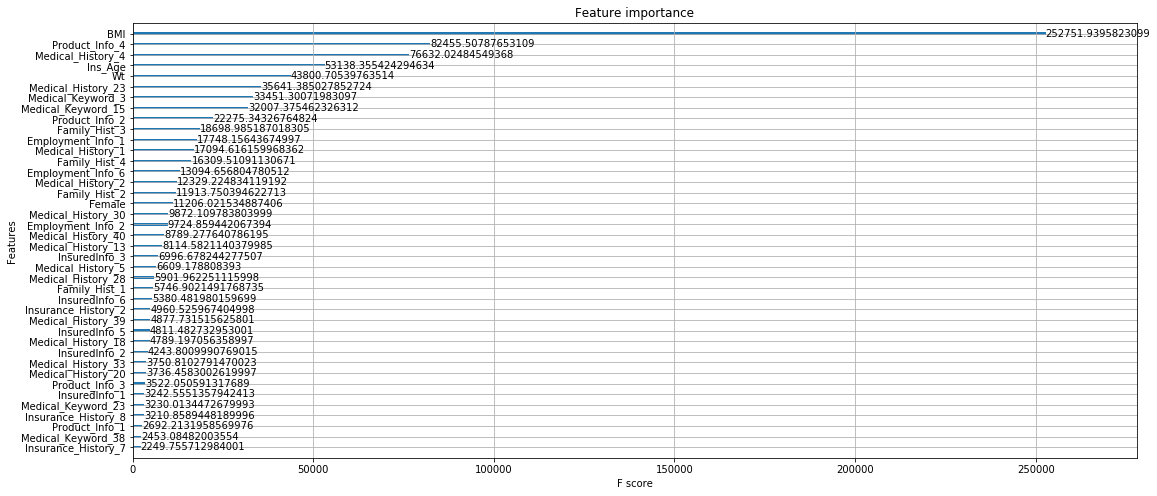

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 8)
_ = xgb.plot_importance(models[0], importance_type='total_gain',max_num_features=40)

In [0]:
# xgb_importance1=pd.DataFrame({'importance':models[0].feature_importances_,'var':data.columns})
feature_importance = [[],[],[],[]]
for i in range(4):
  xgb_importance = models[i].get_booster().get_score(importance_type="total_gain")
  xgb_importance = sorted(xgb_importance.items(),key=lambda item:item[-1],reverse=True)
  for item in xgb_importance:
    feature_importance[i].append(item[0])
  feature_importance[i] = feature_importance[i][:25]

In [0]:
important_features = [x for x in feature_importance[0] if (x in feature_importance[1])and(x in feature_importance[2])and(x in feature_importance[3]and(x in rf_important_features))]
print(important_features)
print(len(important_features),'features')

['BMI', 'Product_Info_4', 'Medical_History_4', 'Ins_Age', 'Wt', 'Medical_History_23', 'Medical_Keyword_3', 'Medical_Keyword_15', 'Product_Info_2', 'Family_Hist_3', 'Employment_Info_1', 'Medical_History_1', 'Family_Hist_4', 'Employment_Info_6', 'Medical_History_2', 'Family_Hist_2', 'Female', 'Medical_History_30', 'Employment_Info_2', 'Medical_History_40', 'Medical_History_13', 'InsuredInfo_3']
22 features


#### Run XGBoost and Random Forest again using new set of features

In [0]:
# here we can also use grid search to find the best hyperparameters to tune the model
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(max_depth=10,n_estimators=2000)
clf_rf.fit(X_train[important_features],y_train)
print('validation set presicion:',clf_rf.score(X_validation[important_features],y_validation))
print('training set precision:',clf_rf.score(X_train[important_features],y_train))

validation set presicion: 0.5237545028206348
training set precision: 0.589138856793312


In [0]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
from tqdm import tqdm
folds = 4
seed = 0
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
models2 = []
for tr_idx, val_idx in tqdm(kf.split(data[important_features],y_data)):
    def fit_classifier(tr_idx, val_idx):
        tr_x, tr_y = data[important_features][list(data[important_features])].iloc[tr_idx], y_data[tr_idx]
        vl_x, vl_y = data[important_features][list(data[important_features])].iloc[val_idx], y_data[val_idx]
        print({'train size':len(tr_x), 'eval size':len(vl_x)})

        tr_data = xgb.DMatrix(tr_x, label=tr_y)
        vl_data = xgb.DMatrix(vl_x, label=vl_y)  
        xgb.XGBClassifier()
        clf = xgb.XGBClassifier(n_estimators=2000,
                                learning_rate=0.01,
                                feature_fraction=1,
                                max_depth = 10,
                                subsample=0.25,  
                                subsample_freq=1,
                                lambda_l1=0.3,  
                                lambda_l2=0.3,
                                num_leaves=30,
                                tree_method = 'gpu_hist',
                                metric='mse')
        clf.fit(tr_x, tr_y,
                eval_set=[(tr_x, tr_y),(vl_x, vl_y)],
                early_stopping_rounds=150,
                verbose=250)
        return clf
    clf = fit_classifier(tr_idx, val_idx)
    models2.append(clf)

0it [00:00, ?it/s]

{'train size': 44139, 'eval size': 14713}
[0]	validation_0-merror:0.481343	validation_1-merror:0.510501
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.376991	validation_1-merror:0.456807
Stopping. Best iteration:
[220]	validation_0-merror:0.382768	validation_1-merror:0.456059



1it [00:54, 54.92s/it]

{'train size': 44139, 'eval size': 14713}
[0]	validation_0-merror:0.471669	validation_1-merror:0.506695
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.378645	validation_1-merror:0.464079
Stopping. Best iteration:
[288]	validation_0-merror:0.373139	validation_1-merror:0.46272



2it [01:58, 57.60s/it]

{'train size': 44139, 'eval size': 14713}
[0]	validation_0-merror:0.47611	validation_1-merror:0.509006
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.377104	validation_1-merror:0.469721
[500]	validation_0-merror:0.337887	validation_1-merror:0.466526
[750]	validation_0-merror:0.296948	validation_1-merror:0.466526
Stopping. Best iteration:
[632]	validation_0-merror:0.316772	validation_1-merror:0.465507



3it [03:49, 73.41s/it]

{'train size': 44139, 'eval size': 14713}
[0]	validation_0-merror:0.471488	validation_1-merror:0.511792
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 150 rounds.
[250]	validation_0-merror:0.377671	validation_1-merror:0.466458
[500]	validation_0-merror:0.339858	validation_1-merror:0.465643
Stopping. Best iteration:
[447]	validation_0-merror:0.347652	validation_1-merror:0.463943



4it [05:13, 76.81s/it]


In [0]:
for i in range(4):
  print('model'+str(i),models2[i].score(data[important_features],y_data))
print('model'+str(5),clf_rf.score(data[important_features],y_data))

model0 0.5989091279820566
model1 0.6044654387276558
model2 0.6460443145517569
model3 0.6232753347379868
model5 0.5727927683001427


In [0]:
res_preds = []
for i in range(4):
  res_preds.append(models2[i].predict(data[important_features]))
res_preds.append(clf_rf.predict(data[important_features]))
res = []
for i in range(len(y_data)):
  res_temp = []
  for j in range(5): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
print('total dataset precision hard voting:',accuracy_score(y_data, res))

total dataset precision hard voting: 0.620165839733569


In [0]:
res_preds = []
for i in range(4):
  res_preds.append(models2[i].predict(data[important_features]))
res = []
for i in range(len(y_data)):
  res_temp = []
  for j in range(4): 
    res_temp.append(res_preds[j][i])
  res.append(np.argmax(np.bincount(res_temp)))
print('total dataset precision hard voting:',accuracy_score(y_data, res))

total dataset precision hard voting: 0.6300210698022157


In [0]:
from sklearn.metrics import classification_report as cr
print(cr(y_data,models2[2].predict(data[important_features])))

              precision    recall  f1-score   support

           1       0.74      0.41      0.53      6156
           2       0.76      0.41      0.54      6491
           3       0.87      0.27      0.41      1007
           4       0.67      0.29      0.40      1420
           5       0.73      0.62      0.67      5388
           6       0.55      0.64      0.59     11131
           7       0.56      0.48      0.52      7943
           8       0.67      0.93      0.78     19316

    accuracy                           0.65     58852
   macro avg       0.69      0.51      0.55     58852
weighted avg       0.66      0.65      0.63     58852



# According to the results, Models[2] has the top accuracy: 64.4%